In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from gwpy.timeseries import TimeSeries
from pycbc.frame import read_frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import matched_filter

In [3]:
raw_data = read_frame("challenge2.gwf", "H1:CHALLENGE2")
print("Duration: {}".format(raw_data.duration))
print("Sampling rate: {}".format(raw_data.sample_rate))

Duration: 128.0
Sampling rate: 4096.0


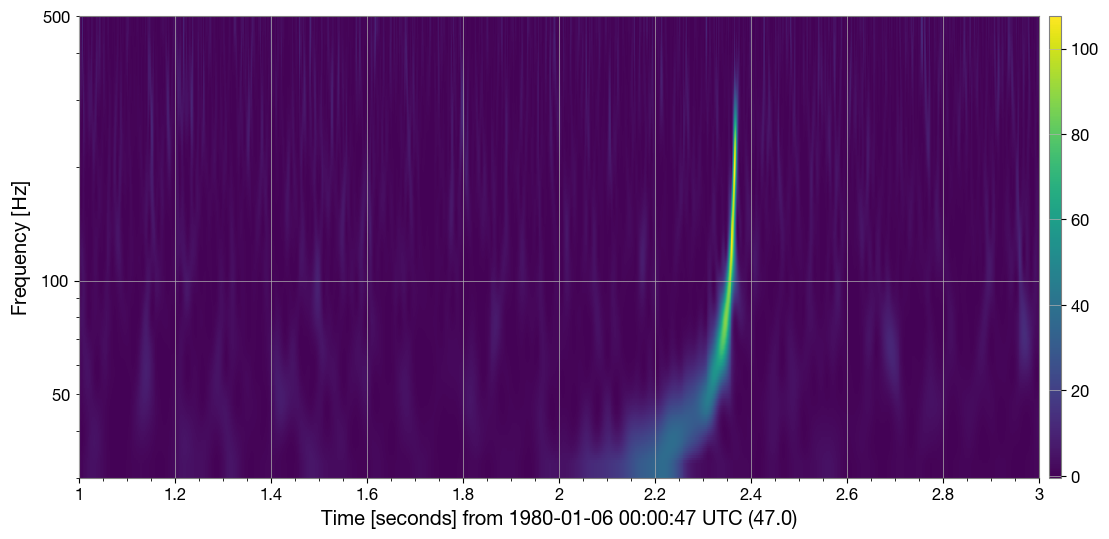

In [7]:
def plot_q(strain, outseg=None):
    q = TimeSeries.from_pycbc(strain).q_transform(frange=(30, 500), outseg=outseg)
    fig = q.plot()
    fig.colorbar()
    ax = fig.gca()
    ax.set_yscale('log')
    return fig

_ = plot_q(raw_data, outseg=(48, 50))

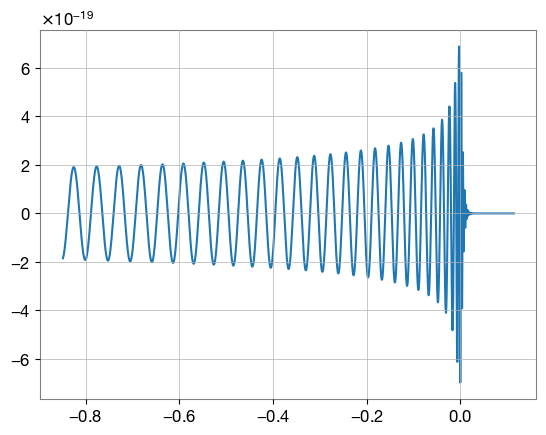

In [8]:
def get_template(cmass, delta_t, approximant="SEOBNRv4_opt"):
    hp, _ = get_td_waveform(
                    approximant=approximant,
                    mass1=cmass,
                    mass2=cmass,
                    delta_t=delta_t,
                    f_lower=20)
    return hp

template = get_template(30, delta_t=raw_data.delta_t)
plt.plot(template.sample_times, template)

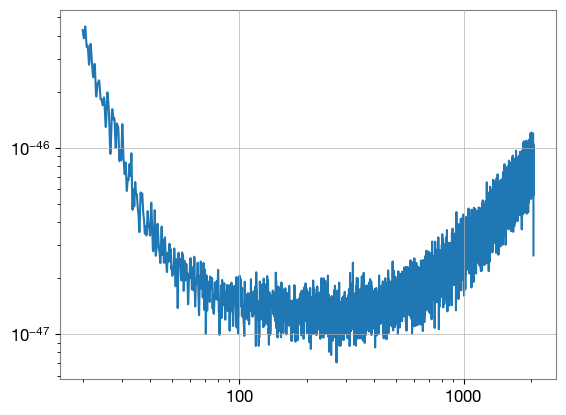

In [11]:
def get_psd(data):
    psd = data.psd(4)
    psd = interpolate(psd, data.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * data.sample_rate),
                                      low_frequency_cutoff=15)
    return psd

data = raw_data.crop(2, 2)
psd = get_psd(data)

mask = psd.sample_frequencies > 20
mask &= psd.sample_frequencies < data.sample_rate/2
plt.loglog(psd.sample_frequencies[mask], psd.data[mask])

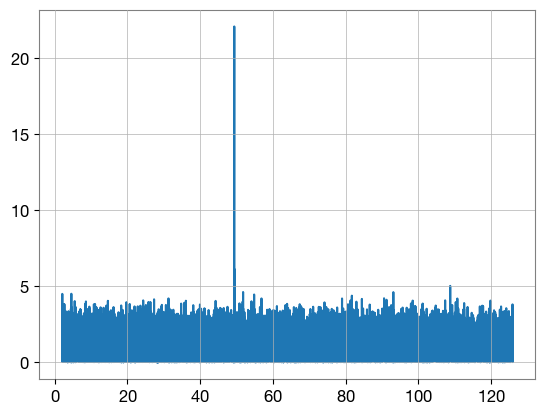

In [12]:
def get_snr(template, data, psd):
    template.resize(len(data))
    template = template.cyclic_time_shift(template.start_time)
    snr = matched_filter(template, data, psd=psd, low_frequency_cutoff=20)
    return snr

snr = get_snr(template, data, psd)
plt.plot(snr.sample_times, abs(snr))

In [13]:
idx = np.argmax(abs(snr))
time = snr.sample_times[idx]
snrp = snr.data[idx]
print(time, abs(snrp))

49.3671875 22.05982482790438
